# Analyse the AW shape in CREG12.L75 experiments

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap

%matplotlib inline

>> Function definition START

In [2]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [3]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [4]:
def awtmax_depth (temp,sal,zdim,deptht,zmask=None):
    #%%time 
    mask = (sal > 33.5) 
    ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Transform the nupy array into a data array
    final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])
    
    return temp_map, final_true_depth

>> Function definition END

# CREG12.L75-REF12 Grid

In [5]:
GRIDPATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG12.L75-REF12_mesh_mask_domain_cfg_20230810_Z.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(nav_lev=0,time_counter=0)

# Read the initial state based on WOA09

In [6]:
PATHIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_woa09=xr.open_dataset(PATHIN+'CREG12.L75-REF12_init_gridT.nc')

vosaline=ds_woa09['vosaline'].isel(time_counter=0)
votemper=ds_woa09['votemper'].isel(time_counter=0)

In [7]:
ds_woa09

<xarray.Dataset>
Dimensions:       (y: 1801, x: 1580, nav_lev: 75, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/22)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    votemper      (time_counter, nav_lev, y, x) float64 ...
    vosaline      (time_counter, nav_lev, y, x) float64 ...
    sossheig      (time_counter, y, x) float64 ...
    vozocrtx      (time_counter, nav_lev, y, x) float64 ...
    ...            ...
    soshfldo      (time_counter, y, x) float64 ...
    soicecov      (time_counter, y, x) float64 ...
    sozotaux      (time_counter, y, x) float64 ...
    sometauy      (time_counter, y, x) float64 ...
    vovvldep      (time_counter, nav_lev, y, x) float64 ...
    vovvle3t      (time_counter, nav_lev, y, x) float64 ...
Attributes:
    file_name:  output.init.nc
    TimeStamp:  19/04/2024 17:34:34 +0200

# Compute the corresponding AWTmax & depth 

In [8]:
temp_map, depth_map = awtmax_depth(votemper,vosaline,'nav_lev',np.array(ds_woa09['nav_lev']),zmask=tmask2D)

(1801, 1580)


/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/xarray/core/common.py:165: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self.values, dtype=dtype)


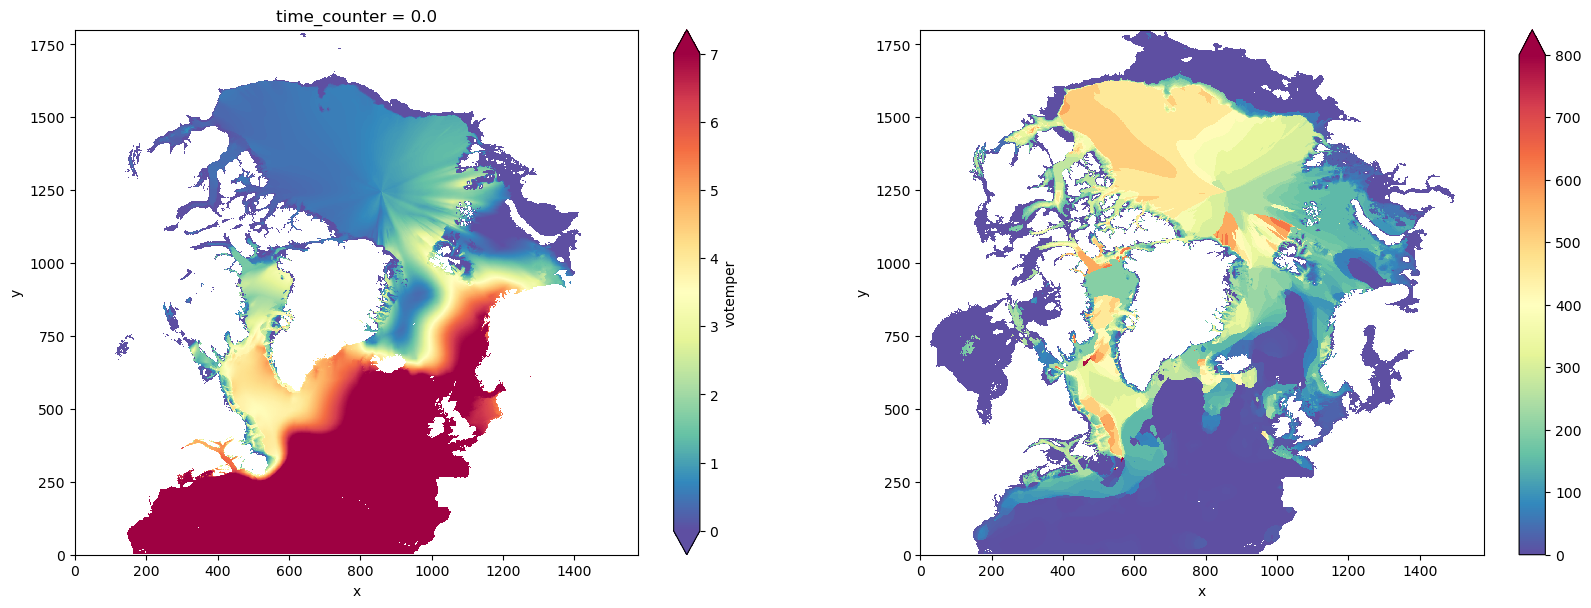

In [9]:
plt.figure(figsize=(20,15))
plt.subplot(221)
temp_map.plot(cmap='Spectral_r',vmin=0.,vmax=7.)
plt.subplot(222)
depth_map.plot(cmap='Spectral_r',vmin=0.,vmax=800.)

# Test an initial state without drawbacks of WOA09 star shape in the Arctic

In [12]:
DATAPATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF12-MEAN/1m/2000/'
ds_init=xr.open_dataset(DATAPATH+'CREG12.L75-REF12_y2000.1d_gridT.nc')
sal_ini=ds_init['vosaline'].isel(time_counter=0)
tem_ini=ds_init['votemper'].isel(time_counter=0)
# Get the depth 1D and transform it into an numpy array to iterate on it
depth=np.array(tem_ini.deptht)

In [13]:
# Get the AWTmax and associated depth 
init_awtmax, init_awdepth = awtmax_depth(tem_ini,sal_ini,'deptht',depth,zmask=tmask2D)

(1801, 1580)


/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/xarray/core/common.py:165: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self.values, dtype=dtype)


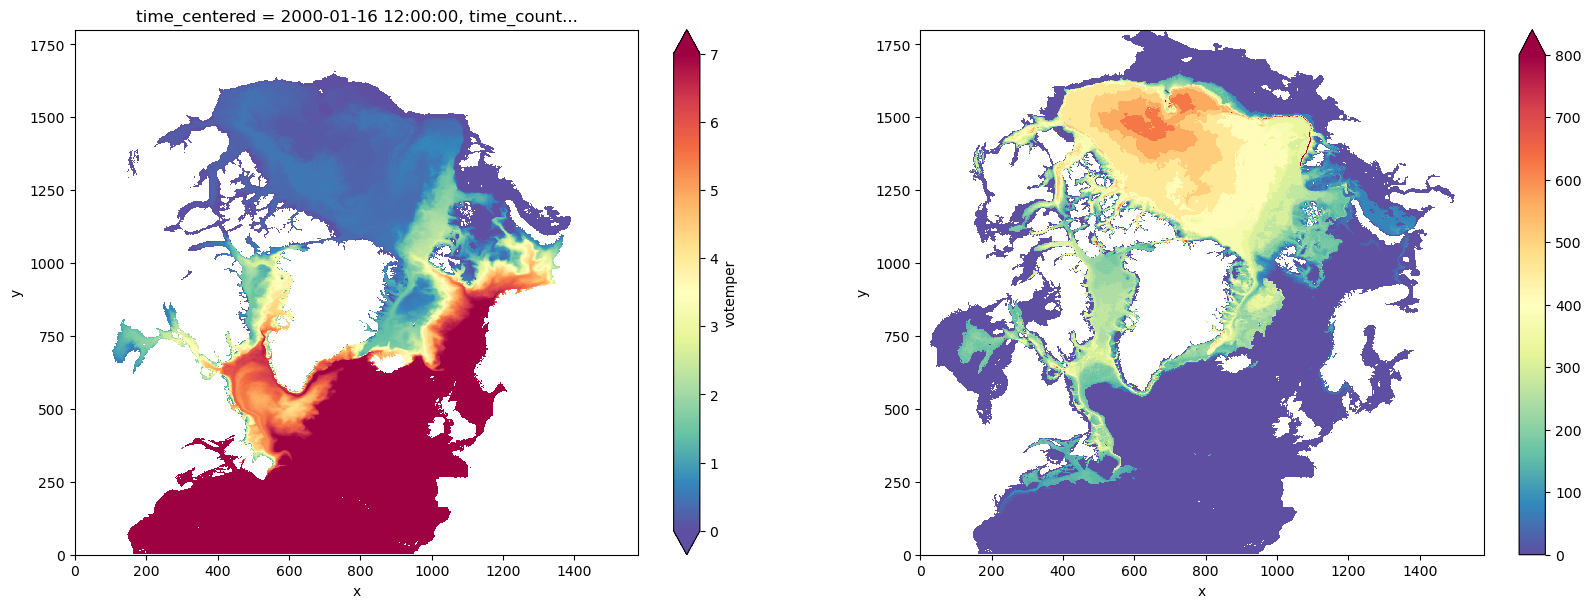

In [14]:
plt.figure(figsize=(20,15))
plt.subplot(221)
init_awtmax.plot(cmap='Spectral_r', vmin=0.,vmax=7.)
plt.subplot(222)
init_awdepth.plot(cmap='Spectral_r',vmin=0.,vmax=800.)

# Read input Data processed by the Arctic Monitoring

In [14]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

In [25]:
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/'
year=2000
#ds_AW=xr.open_dataset(DATA_PATH+'CREG12.L75-REF12_AWTmaxClim_y'+str(year)+'.nc')
ds_AW=xr.open_mfdataset(DATA_PATH+'CREG12.L75-REF12_AWTmaxClim_y*.nc',concat_dim='time_counter',combine='nested')

In [26]:
AWTmax=clean_AM_AWtmax_depth(ds_AW['AWTmax_mod'],tmask2D)
AWTmaxDepth_mod=clean_AM_AWtmax_depth(ds_AW['AWTmaxDepth_mod'],tmask2D)

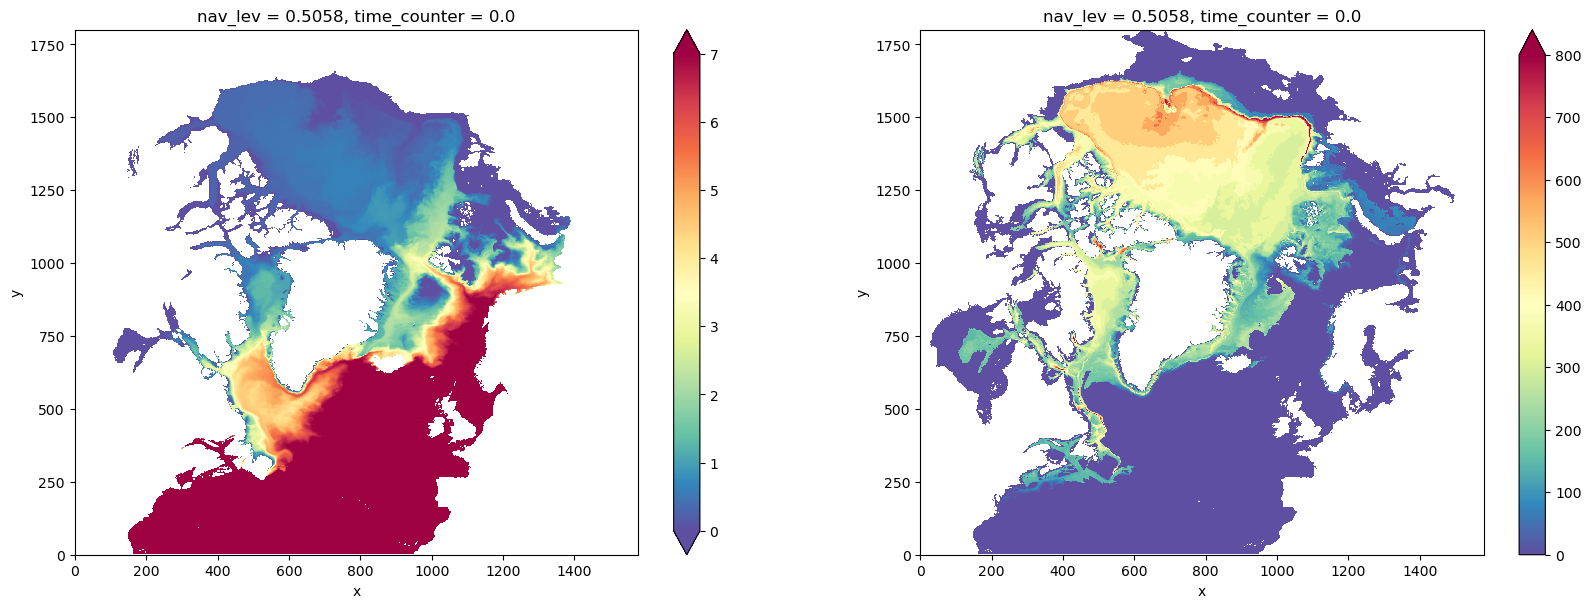

In [27]:
plt.figure(figsize=(20,15))
plt.subplot(221) 
AWTmax.isel(time_counter=10).plot(cmap='Spectral_r',vmin=0.,vmax=7.)
plt.subplot(222) 
AWTmaxDepth_mod.isel(time_counter=10).plot(cmap='Spectral_r',vmin=0.,vmax=800.)

# Read the full years input Data processed by the Arctic Monitoring

In [6]:
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/'
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()
AW_files = [f for f in fs.glob(DATA_PATH+'CREG12.L75-REF12_AWTmaxClim_y*.nc')]
AW_files                           

['/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1979.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1980.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1981.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1982.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1983.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L75-REF12/MAPS/NCDF/CREG12.L75-REF12_AWTmaxClim_y1984.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/MONITOR/CREG12.L7

In [7]:
ds_AW=xr.open_mfdataset(AW_files,concat_dim='time_counter',combine='nested')
ds_AW

<xarray.Dataset>
Dimensions:           (time_counter: 39, y: 1801, x: 1580, yobs: 180, xobs: 360)
Dimensions without coordinates: time_counter, y, x, yobs, xobs
Data variables:
    AWTmax_mod        (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    AWTmax_init       (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AWTmaxDepth_mod   (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    AWTmaxDepth_init  (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_obs           (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lon_obs           (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_mod           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    lon_mod           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    description:  Diagnostics has been calculated using the Arctic monitoring...
    date:         Thu Aug 22 20:43:41 CEST 2024\n

In [8]:
new_time=pd.date_range(start='1979-07',end='2017-07',periods=39,normalize=True)
new_time

DatetimeIndex([          '1979-07-01 00:00:00',
               '1980-06-30 06:18:56.842105264',
               '1981-06-30 12:37:53.684210528',
               '1982-06-30 18:56:50.526315792',
               '1983-07-01 01:15:47.368421056',
               '1984-06-30 07:34:44.210526336',
               '1985-06-30 13:53:41.052631584',
               '1986-06-30 20:12:37.894736832',
               '1987-07-01 02:31:34.736842112',
               '1988-06-30 08:50:31.578947392',
               '1989-06-30 15:09:28.421052672',
               '1990-06-30 21:28:25.263157888',
               '1991-07-01 03:47:22.105263168',
               '1992-06-30 10:06:18.947368448',
               '1993-06-30 16:25:15.789473664',
               '1994-06-30 22:44:12.631578944',
               '1995-07-01 05:03:09.473684224',
               '1996-06-30 11:22:06.315789504',
               '1997-06-30 17:41:03.157894784',
                         '1998-07-01 00:00:00',
               '1999-07-01 06:18:56.8421

In [9]:
ds_AW=ds_AW.assign_coords({'time_counter':new_time})
ds_AW

<xarray.Dataset>
Dimensions:           (time_counter: 39, y: 1801, x: 1580, yobs: 180, xobs: 360)
Coordinates:
  * time_counter      (time_counter) datetime64[ns] 1979-07-01 ... 2017-07-01
Dimensions without coordinates: y, x, yobs, xobs
Data variables:
    AWTmax_mod        (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    AWTmax_init       (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AWTmaxDepth_mod   (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    AWTmaxDepth_init  (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_obs           (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lon_obs           (time_counter, yobs, xobs) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lat_mod           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    lon_mod           (time_counter, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    description:  Diagnostics has been calculated using the Arctic monitoring...
    date:         Thu Aug 22 20:43:41 CEST 2024\n

In [10]:
# Make 2D diff between year & year-1 
Diff_AWTmaxDepth_mod=ds_AW.AWTmaxDepth_mod-ds_AW.AWTmaxDepth_mod.roll(time_counter=+1)
Diff_AWTmaxDepth_mod

<xarray.DataArray 'AWTmaxDepth_mod' (time_counter: 39, y: 1801, x: 1580)>
dask.array<sub, shape=(39, 1801, 1580), dtype=float32, chunksize=(1, 1801, 1580), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-07-01 ... 2017-07-01
Dimensions without coordinates: y, x

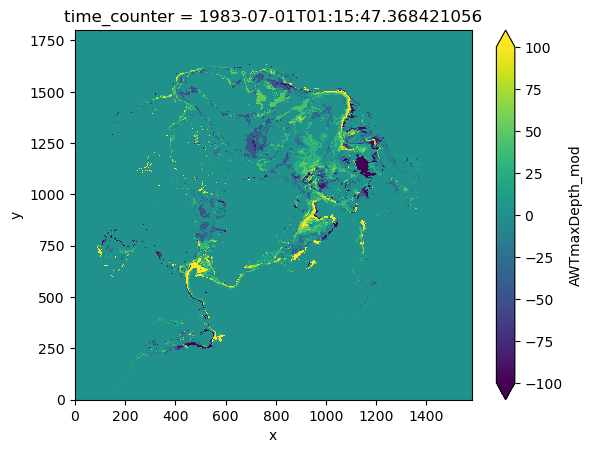

In [12]:
Diff_AWTmaxDepth_mod.sel(time_counter='1983').plot(vmin=-100.,vmax=100.)

In [15]:
clean_Diff_AWTmaxDepth_mod=clean_AM_AWtmax_depth(Diff_AWTmaxDepth_mod,tmask2D)

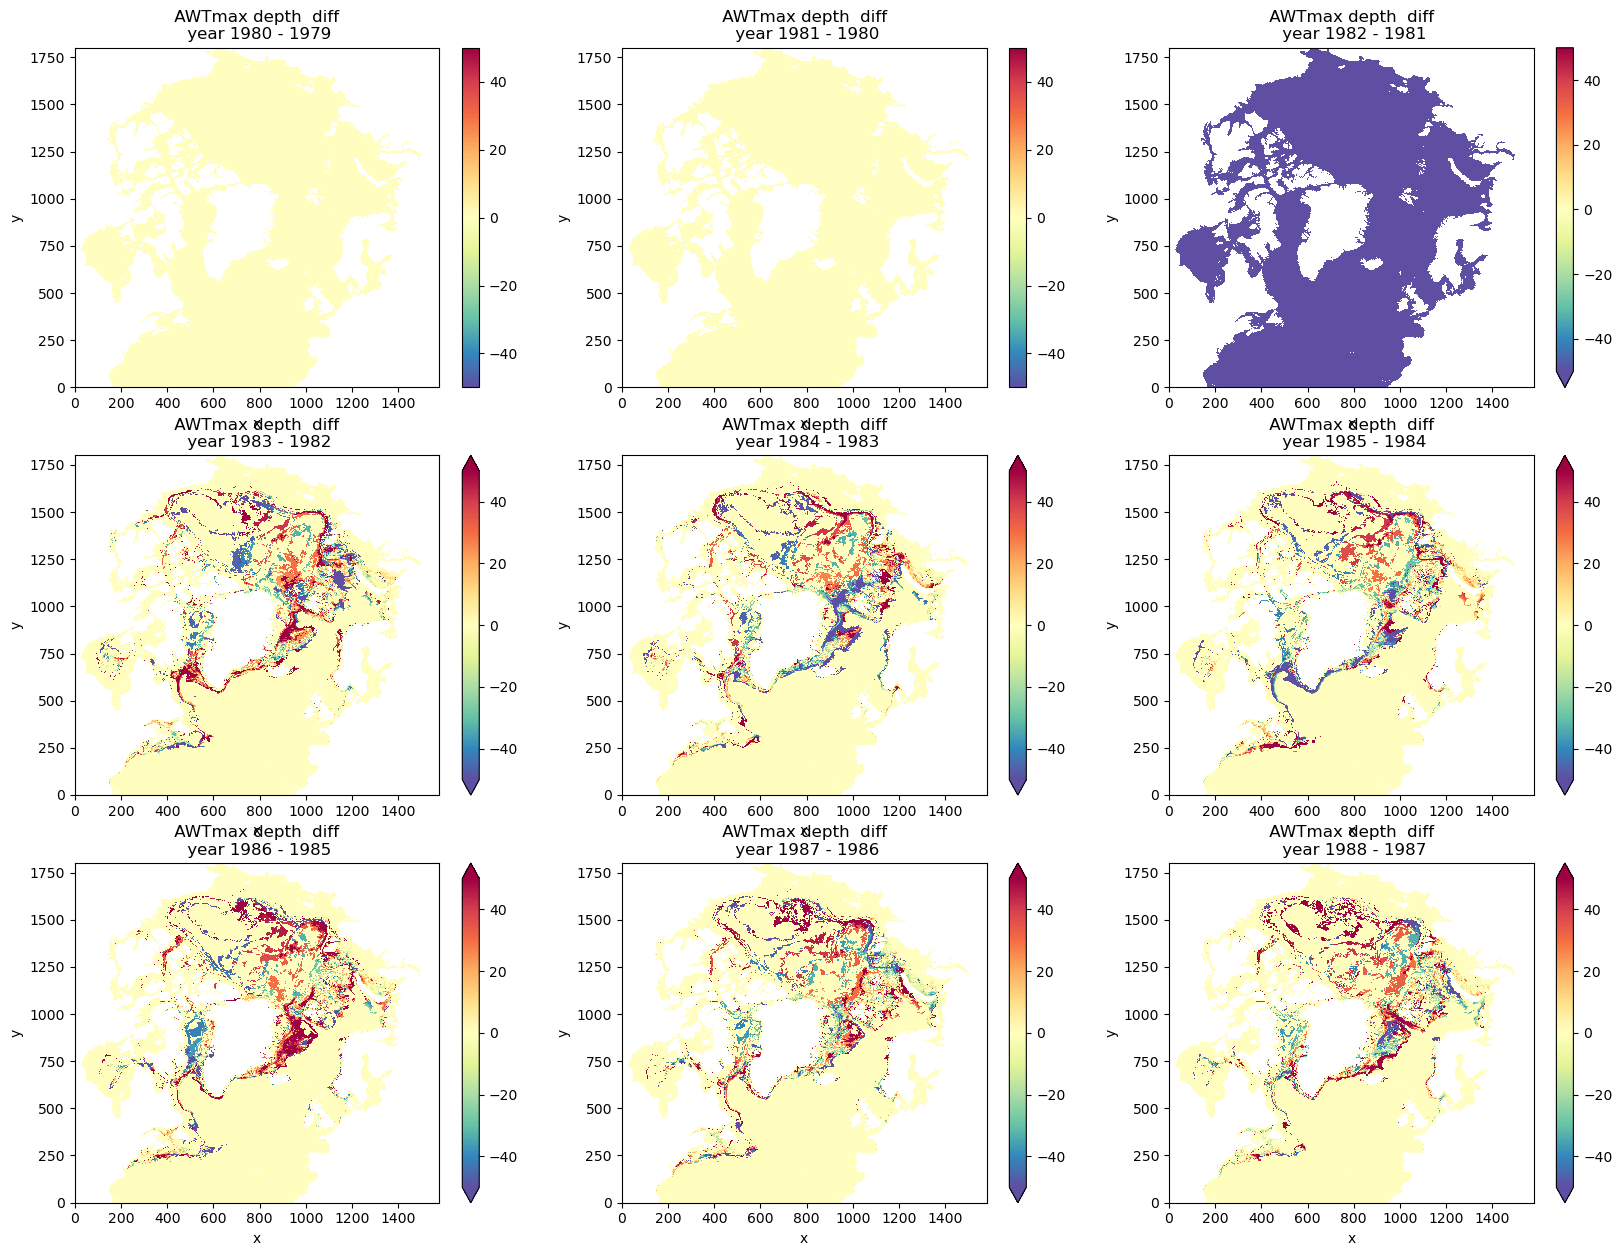

In [26]:
plt.figure(figsize=(20,15))
y_start=1980
for iter in np.arange(9):
    plt.subplot(331+iter)
    clean_Diff_AWTmaxDepth_mod.sel(time_counter=str(y_start+iter)).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
    plt.title(' AWTmax depth  diff \n'+' year '+str(y_start+iter)+' - '+str(y_start+iter-1))

/dev/shm/pbs.457738.datarmor0/ipykernel_22172/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.457738.datarmor0/ipykernel_22172/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.457738.datarmor0/ipykernel_22172/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.457738.datarmor0/ipykernel_22172/768119356.py

type: "not all values found in index 'time_counter'. Try setting the `method` keyword argument (example: method='nearest')."

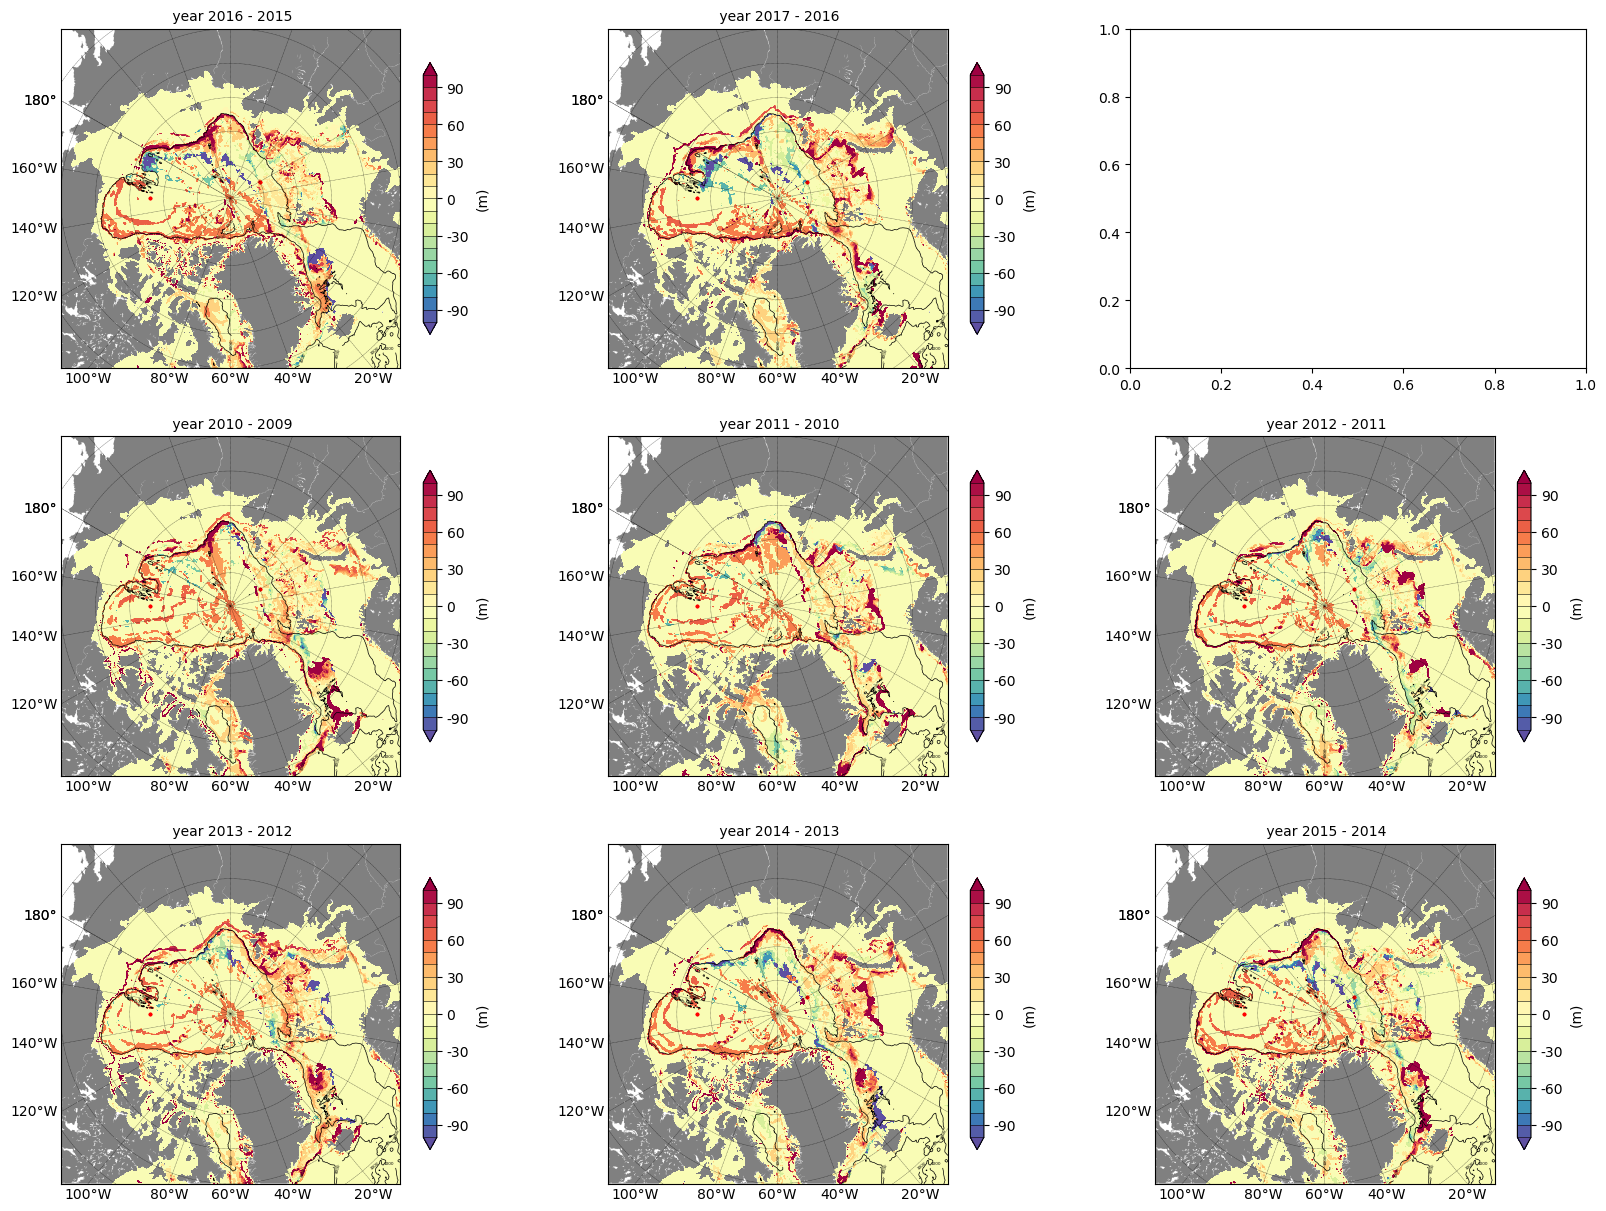

In [39]:
doplot=True
if doplot:
        plt.figure(figsize=(20,15)) 
        #plt.subplot(223)
        ######### AWTmax #########
        my_cblab=r'(m)'
        my_cmap=plt.colormaps['Spectral_r']
        #my_cmap=mpl.cm.get_cmap('Spectral_r')
        #my_cmap=plt.cm.get_cmap('jet')

        m_alpha=1.
        zfile_ext='_AWTmaxDepth'
        vmin=-100. ; vmax=100. ; vint=10.
        contours=np.arange(vmin,vmax+vint,vint)  # optional contours
        limits=[vmin,vmax,vint]                        # limits for eke
        myticks=np.arange(vmin,vmax+vint,vint)   # optional colorbar ticks (None)    
        
        l_lon=ds_AW['lon_mod'].isel(time_counter=0).values
        l_lat=ds_AW['lat_mod'].isel(time_counter=0).values

        #y_start=1980 ; 
        faces=9
        for y_start in np.arange(0,30,faces)+1989:
            for iter in np.arange(faces):
                plt.subplot(331+iter)   
                l_fld=clean_Diff_AWTmaxDepth_mod.sel(time_counter=str(y_start+iter))[:,:,0]
                zoutmap=Arc_Bat(ztype='isol1000')
                ztitle=r' year '+str(y_start+iter)+' - '+str(y_start+iter-1)
                Arc_plot(l_lon,l_lat, l_fld*m_alpha, contours, limits, myticks, \
                         name=ztitle, zmy_cblab=my_cblab, zmy_cmap=my_cmap, zvar='socurl')

            plt.savefig('CREG12.L75-REF12_AWTmaxDepthIncrement_y'+str(y_start)+str(y_start+faces-1)+'.png',dpi=300)
    
doplot=False


/dev/shm/pbs.455739.datarmor0/ipykernel_27590/3206052435.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap=plt.cm.get_cmap('Spectral_r')
/dev/shm/pbs.455739.datarmor0/ipykernel_27590/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


type: Mask and data not compatible: data size is 2845580, mask size is 110977620.

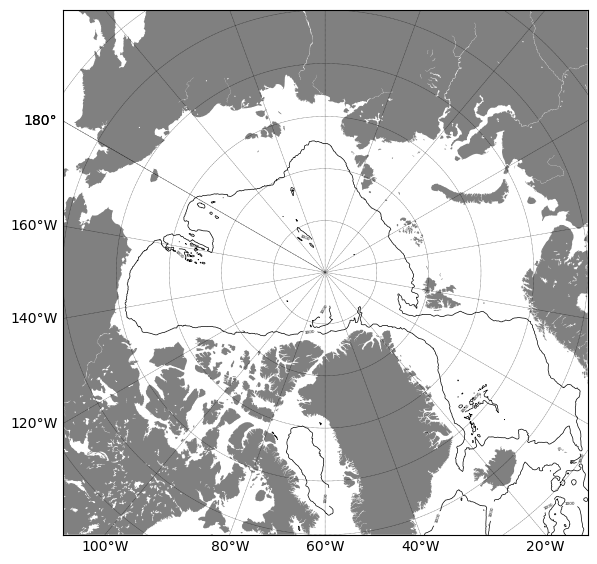

In [131]:
doplot=True
if doplot:
        plt.figure(figsize=(20,15))
        plt.subplot(221)
        ######### AWTmax #########
        my_cblab=r'(DegC)'
        my_cmap=plt.cm.get_cmap('Spectral_r')
        #my_cmap=plt.cm.get_cmap('Blues')

        m_alpha=1.
        zfile_ext='_AWTmax'
        ztitle=r'CREG12.L75 WOA09 AWTmax '
        vmin=0. ; vmax=7. ; vint=0.25
        contours=np.arange(vmin,vmax+vint,vint)  # optional contours
        limits=[vmin,vmax,vint]                        # limits for eke
        myticks=np.arange(vmin,vmax+vint,vint)   # optional colorbar ticks (None)    
        
        zoutmap=Arc_Bat(ztype='isol1000')
        Arc_plot(np.array(ds_AW['lon_mod']), np.array(ds_AW['lat_mod']), np.array(temp_map)*m_alpha, contours, \
                 limits, myticks, name=ztitle, zmy_cblab=my_cblab, zmy_cmap=my_cmap, zvar='socurl')

 
        plt.subplot(223)
        ######### AWTmax #########
        my_cblab=r'(m)'
        #my_cmap=plt.cm.get_cmap('Spectral_r')
        my_cmap=plt.cm.get_cmap('jet')

        m_alpha=1.
        zfile_ext='_AWTmaxDepth'
        ztitle=r'CREG12.L75 REF12 AWTmax depth '
        vmin=0. ; vmax=800. ; vint=50.
        contours=np.arange(vmin,vmax+vint,vint)  # optional contours
        limits=[vmin,vmax,vint]                        # limits for eke
        myticks=np.arange(vmin,vmax+vint,vint)   # optional colorbar ticks (None)    
        
        zoutmap=Arc_Bat(ztype='isol1000')
        Arc_plot(np.array(ds_AW['lon_mod']), np.array(ds_AW['lat_mod']), np.array(AWTmaxDepth_mod)*m_alpha, contours, \
                 limits, myticks, name=ztitle, zmy_cblab=my_cblab, zmy_cmap=my_cmap, zvar='socurl')

        
        
        #plt.savefig('figtest.pdf')
    
doplot=False
